# Desafio complementar

In [97]:
import pandas as pd 
import requests
import numpy as np
import seaborn as sns 
import sqlite3
from plyer import notification
from datetime import datetime

## 00. Constantes e Funções auxiliares

In [98]:
DB_PATH = "restcountries.db"

In [99]:
def alerta(nivel, base, etapa):
    """
    Retorna um alerta no desktop

    :param nivel: Nível do alerta
    :param base: Base onde ocorreu a falha
    :param etapa: Etapa onde ocorreu a falha

    :type nivel: int
    :type base: str
    :type etapa: str
    """

    niveis = {1:"Baixo",
          2: "Médio",
          3: "Alto"}

    if nivel not in niveis:
        raise ValueError(f"Nível inválido. Deve ser 1, 2 ou 3")
    
    alerta = notification.notify(title=f"ATENÇÃO: Alerta {niveis[nivel]}",
                               message=f"Falha no carregamento da base {base} na etapa {etapa}\n{datetime.now()}")
    return notifi

def get_req(url, base="base"):
    """
    Retorna o JSON de uma requisição a uma API. Em caso de resposta diferente de 200, retorna um alerta.

    :param url: URL da API
    :param base: Nome da base que será criada

    :type url: str
    :type base: str
    """
    # Trata respostas diferentes da esperada (200)
    req = requests.get(url)
    if req.status_code != 200:
        return alerta(1, base, "Extração")
    
    else:
        return req.json()

def tabelas_bd(path=DB_PATH):
    """Retorna todas as tabelas da DB especificada

    Args:
        path (str, optional): caminho da db. Padrão DB_PATH.

    Returns:
        pandas.DataFrame: Dataframe contendo as tabelas da DB
    """
    conn = sqlite3.connect(path = DB_PATH)
    query = "SELECT name FROM sqlite_master WHERE type='table'"
    schema = pd.read_sql(query, conn)
    conn.close()
    
    return schema
    
def salva_bd(df, nome_tabela):
    """Salva o DataFrame como uma tabela na base de dados

    Args:
        df (pandas.DataFrame): Tabela a ser inserida na base de dados
        nome_tabela (str): Nome da tabela a ser inserida

    Returns:
        bool: True
    """
    conn = sqlite3.connect(path)
    salva_df = df.to_sql(nome_tabela, conn, if_exists='replace', index=False)
    conn.close()

    return salva_df

def carrega_bd(nome_tabela, path = DB_PATH):
    """Carrega a tabela referenciada na base de dados

    Args:
        nome_tabela (str): Nome da tabela
        path (str, optional): Caminho para a base de dados. Padrão DB_PATH.

    Returns:
        pandas.DataFrame: Tabela em formato de DataFrame
    """
    conn = sqlite3.connect(path)
    query = f"SELECT * FROM {nome_tabela}"
    df_query = pd.read_sql(query, conn)
    conn.close()

    return df_query
    

## 01. Premissas para extração
Para esta atividade, utilizaremos a API REST Countries

Vamos extrair 3 tabelas a partir da requisição

In [100]:
# Definimos 
url = "https://restcountries.com/v3.1/all"
req = get_req(url)

In [101]:
print(f"Entradas na tabela: {len(req)}")

dados_disponiveis = list(req[0].keys())
print(f"Dados disponíveis: {dados_disponiveis}")



Entradas na tabela: 250
Dados disponíveis: ['name', 'tld', 'cca2', 'ccn3', 'cca3', 'cioc', 'independent', 'status', 'unMember', 'currencies', 'idd', 'capital', 'altSpellings', 'region', 'subregion', 'languages', 'translations', 'latlng', 'landlocked', 'area', 'demonyms', 'flag', 'maps', 'population', 'gini', 'fifa', 'car', 'timezones', 'continents', 'flags', 'coatOfArms', 'startOfWeek', 'capitalInfo', 'postalCode']


## 02. Extração das tabelas 

### 02.00 - Tabela 0
TUDO!

A própria requisição inteiramente transformada em um DataFrame

In [102]:
extract = [i[key] if str(key) in i else np.nan for key in dados_disponiveis for i in req]
df_req = pd.DataFrame(req)
df_req

,name,tld,cca2,ccn3,cca3,cioc,independent,status,unMember,currencies,...,fifa,car,timezones,continents,flags,coatOfArms,startOfWeek,capitalInfo,postalCode,borders
0,"{'common': 'Cyprus', 'official': 'Republic of ...",[.cy],CY,196,CYP,CYP,True,officially-assigned,True,"{'EUR': {'name': 'Euro', 'symbol': '€'}}",...,CYP,"{'signs': ['CY'], 'side': 'left'}",[UTC+02:00],[Europe],"{'png': 'https://flagcdn.com/w320/cy.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [35.17, 33.37]}","{'format': '####', 'regex': '^(\d{4})$'}",NaN
1,"{'common': 'Eritrea', 'official': 'State of Er...",[.er],ER,232,ERI,ERI,True,officially-assigned,True,"{'ERN': {'name': 'Eritrean nakfa', 'symbol': '...",...,ERI,"{'signs': ['ER'], 'side': 'right'}",[UTC+03:00],[Africa],"{'png': 'https://flagcdn.com/w320/er.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [15.33, 38.93]}",NaN,"[DJI, ETH, SDN]"
2,"{'common': 'Liberia', 'official': 'Republic of...",[.lr],LR,430,LBR,LBR,True,officially-assigned,True,"{'LRD': {'name': 'Liberian dollar', 'symbol': ...",...,LBR,"{'signs': ['LB'], 'side': 'right'}",[UTC],[Africa],"{'png': 'https://flagcdn.com/w320/lr.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [6.3, -10.8]}","{'format': '####', 'regex': '^(\d{4})$'}","[GIN, CIV, SLE]"
3,"{'common': 'Bermuda', 'official': 'Bermuda', '...",[.bm],BM,060,BMU,BER,False,officially-assigned,False,"{'BMD': {'name': 'Bermudian dollar', 'symbol':...",...,BER,"{'signs': ['GB'], 'side': 'left'}",[UTC-04:00],[North America],"{'png': 'https://flagcdn.com/w320/bm.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [32.28, -64.78]}","{'format': '@@ ##', 'regex': '^([A-Z]{2}\d{2})$'}",NaN
4,"{'common': 'Vatican City', 'official': 'Vatica...",[.va],VA,336,VAT,NaN,True,officially-assigned,True,"{'EUR': {'name': 'Euro', 'symbol': '€'}}",...,NaN,"{'signs': ['V'], 'side': 'right'}",[UTC+01:00],[Europe],"{'png': 'https://flagcdn.com/w320/va.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [41.9, 12.45]}",NaN,[ITA]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,"{'common': 'South Sudan', 'official': 'Republi...",[.ss],SS,728,SSD,SSD,True,officially-assigned,True,"{'SSP': {'name': 'South Sudanese pound', 'symb...",...,SSD,"{'signs': [''], 'side': 'right'}",[UTC+03:00],[Africa],"{'png': 'https://flagcdn.com/w320/ss.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,sunday,"{'latlng': [4.85, 31.62]}",NaN,"[CAF, COD, ETH, KEN, SDN, UGA]"
246,"{'common': 'Honduras', 'official': 'Republic o...",[.hn],HN,340,HND,HON,True,officially-assigned,True,"{'HNL': {'name': 'Honduran lempira', 'symbol':...",...,HON,"{'signs': ['HN'], 'side': 'right'}",[UTC-06:00],[North America],"{'png': 'https://flagcdn.com/w320/hn.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [14.1, -87.22]}","{'format': '@@####', 'regex': '^([A-Z]{2}\d{4}...","[GTM, SLV, NIC]"
247,"{'common': 'Saint Vincent and the Grenadines',...",[.vc],VC,670,VCT,VIN,True,officially-assigned,True,"{'XCD': {'name': 'Eastern Caribbean dollar', '...",...,VIN,"{'signs': ['WV'], 'side': 'left'}",[UTC-04:00],[North America],"{'png': 'https://flagcdn.com/w320/vc.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [13.13, -61.22]}",NaN,NaN
248,"{'common': 'Sri Lanka', 'official': 'Democrati...","[.lk, .இலங்கை, .ලංකා]",LK,144,LKA,SRI,True,officially-assigned,True,"{'LKR': {'name': 'Sri Lankan rupee', 'symbol':...",...,SRI,"{'signs': ['CL'], 'side': 'left'}",[UTC+05:30],[Asia],"{'png': 'https://flagcdn.com/w320/lk.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [6.89, 79.9]}","{'format': '#####', 'regex': '^(\d{5})$'}",[IND]


,sigla_moeda,nome_moeda
380,AED,"{'name': 'United Arab Emirates dirham', 'symbo..."
523,AFN,"{'name': 'Afghan afghani', 'symbol': '؋'}"
760,ALL,"{'name': 'Albanian lek', 'symbol': 'L'}"
1034,AMD,"{'name': 'Armenian dram', 'symbol': '֏'}"
1472,ANG,"{'name': 'Netherlands Antillean guilder', 'sym..."
...,...,...
40120,ZAR,"{'name': 'South African rand', 'symbol': 'R'}"
40173,ZAR,"{'name': 'South African rand', 'symbol': 'R'}"
40231,ZAR,"{'name': 'South African rand', 'symbol': 'R'}"
40257,ZMW,"{'name': 'Zambian kwacha', 'symbol': 'ZK'}"


In [ ]:
display(df_total.explode("tld")
)
for i in df["name"].keys():
    for key in df["name"][i]:
        print(df["name"][i][key])

,name,tld,cca2,ccn3,cca3,cioc,independent,status,unMember,currencies,...,fifa,car,timezones,continents,flags,coatOfArms,startOfWeek,capitalInfo,postalCode,borders
0,"{'common': 'Cyprus', 'official': 'Republic of ...",.cy,CY,196,CYP,CYP,True,officially-assigned,True,"{'EUR': {'name': 'Euro', 'symbol': '€'}}",...,CYP,"{'signs': ['CY'], 'side': 'left'}",[UTC+02:00],[Europe],"{'png': 'https://flagcdn.com/w320/cy.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [35.17, 33.37]}","{'format': '####', 'regex': '^(\d{4})$'}",NaN
1,"{'common': 'Eritrea', 'official': 'State of Er...",.er,ER,232,ERI,ERI,True,officially-assigned,True,"{'ERN': {'name': 'Eritrean nakfa', 'symbol': '...",...,ERI,"{'signs': ['ER'], 'side': 'right'}",[UTC+03:00],[Africa],"{'png': 'https://flagcdn.com/w320/er.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [15.33, 38.93]}",NaN,"[DJI, ETH, SDN]"
2,"{'common': 'Liberia', 'official': 'Republic of...",.lr,LR,430,LBR,LBR,True,officially-assigned,True,"{'LRD': {'name': 'Liberian dollar', 'symbol': ...",...,LBR,"{'signs': ['LB'], 'side': 'right'}",[UTC],[Africa],"{'png': 'https://flagcdn.com/w320/lr.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [6.3, -10.8]}","{'format': '####', 'regex': '^(\d{4})$'}","[GIN, CIV, SLE]"
3,"{'common': 'Bermuda', 'official': 'Bermuda', '...",.bm,BM,060,BMU,BER,False,officially-assigned,False,"{'BMD': {'name': 'Bermudian dollar', 'symbol':...",...,BER,"{'signs': ['GB'], 'side': 'left'}",[UTC-04:00],[North America],"{'png': 'https://flagcdn.com/w320/bm.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [32.28, -64.78]}","{'format': '@@ ##', 'regex': '^([A-Z]{2}\d{2})$'}",NaN
4,"{'common': 'Vatican City', 'official': 'Vatica...",.va,VA,336,VAT,NaN,True,officially-assigned,True,"{'EUR': {'name': 'Euro', 'symbol': '€'}}",...,NaN,"{'signs': ['V'], 'side': 'right'}",[UTC+01:00],[Europe],"{'png': 'https://flagcdn.com/w320/va.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [41.9, 12.45]}",NaN,[ITA]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,"{'common': 'Sri Lanka', 'official': 'Democrati...",.lk,LK,144,LKA,SRI,True,officially-assigned,True,"{'LKR': {'name': 'Sri Lankan rupee', 'symbol':...",...,SRI,"{'signs': ['CL'], 'side': 'left'}",[UTC+05:30],[Asia],"{'png': 'https://flagcdn.com/w320/lk.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [6.89, 79.9]}","{'format': '#####', 'regex': '^(\d{5})$'}",[IND]
248,"{'common': 'Sri Lanka', 'official': 'Democrati...",.இலங்கை,LK,144,LKA,SRI,True,officially-assigned,True,"{'LKR': {'name': 'Sri Lankan rupee', 'symbol':...",...,SRI,"{'signs': ['CL'], 'side': 'left'}",[UTC+05:30],[Asia],"{'png': 'https://flagcdn.com/w320/lk.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [6.89, 79.9]}","{'format': '#####', 'regex': '^(\d{5})$'}",[IND]
248,"{'common': 'Sri Lanka', 'official': 'Democrati...",.ලංකා,LK,144,LKA,SRI,True,officially-assigned,True,"{'LKR': {'name': 'Sri Lankan rupee', 'symbol':...",...,SRI,"{'signs': ['CL'], 'side': 'left'}",[UTC+05:30],[Asia],"{'png': 'https://flagcdn.com/w320/lk.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [6.89, 79.9]}","{'format': '#####', 'regex': '^(\d{5})$'}",[IND]
249,"{'common': 'Hong Kong', 'official': 'Hong Kong...",.hk,HK,344,HKG,HKG,False,officially-assigned,False,"{'HKD': {'name': 'Hong Kong dollar', 'symbol':...",...,HKG,"{'signs': ['HK'], 'side': 'left'}",[UTC+08:00],[Asia],"{'png': 'https://flagcdn.com/w320/hk.png', 'sv...",{'png': 'https://mainfacts.com/media/images/co...,monday,"{'latlng': [22.267, 114.188]}",NaN,[CHN]


Cyprus
Republic of Cyprus
{'ell': {'official': 'Δημοκρατία της Κύπρος', 'common': 'Κύπρος'}, 'tur': {'official': 'Kıbrıs Cumhuriyeti', 'common': 'Kıbrıs'}}
Eritrea
State of Eritrea
{'ara': {'official': 'دولة إرتريا', 'common': 'إرتريا\u200e'}, 'eng': {'official': 'State of Eritrea', 'common': 'Eritrea'}, 'tir': {'official': 'ሃገረ ኤርትራ', 'common': 'ኤርትራ'}}
Liberia
Republic of Liberia
{'eng': {'official': 'Republic of Liberia', 'common': 'Liberia'}}
Bermuda
Bermuda
{'eng': {'official': 'Bermuda', 'common': 'Bermuda'}}
Vatican City
Vatican City State
{'ita': {'official': 'Stato della Città del Vaticano', 'common': 'Vaticano'}, 'lat': {'official': 'Status Civitatis Vaticanæ', 'common': 'Vaticanæ'}}
Cook Islands
Cook Islands
{'eng': {'official': 'Cook Islands', 'common': 'Cook Islands'}, 'rar': {'official': "Kūki 'Āirani", 'common': "Kūki 'Āirani"}}
Somalia
Federal Republic of Somalia
{'ara': {'official': 'جمهورية الصومال\u200e\u200e', 'common': 'الصومال\u200e\u200e'}, 'som': {'official': 'J

,country_id,name,region,subregion
240,240,"{'common': 'Rwanda', 'official': 'Republic of ...",Africa,Eastern Africa
241,241,"{'common': 'North Macedonia', 'official': 'Rep...",Europe,Southeast Europe
242,242,"{'common': 'Kosovo', 'official': 'Republic of ...",Europe,Southeast Europe
243,243,"{'common': 'Netherlands', 'official': 'Kingdom...",Europe,Western Europe
244,244,"{'common': 'Tunisia', 'official': 'Tunisian Re...",Africa,Northern Africa
245,245,"{'common': 'South Sudan', 'official': 'Republi...",Africa,Middle Africa
246,246,"{'common': 'Honduras', 'official': 'Republic o...",Americas,Central America
247,247,"{'common': 'Saint Vincent and the Grenadines',...",Americas,Caribbean
248,248,"{'common': 'Sri Lanka', 'official': 'Democrati...",Asia,Southern Asia
249,249,"{'common': 'Hong Kong', 'official': 'Hong Kong...",Asia,Eastern Asia


<AxesSubplot:xlabel='region', ylabel='Count'>

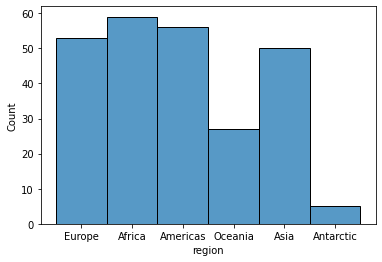

In [ ]:
# Considerar escrever uma função que já trate casos de missing values?
# Utilizaremos um country_id único para juntarmos as tabelas posteriormente

country_id = [i for i in range(len(req))]
t1_names = [i["name"] for i in req]
t1_regions = [i["region"] for i in req]
# Tratamos o caso de não existir a chave "subregion" no JSON da requisição
t1_subregions = [i["subregion"] if "subregion" in i else np.nan for i in req]

df = pd.DataFrame({"country_id": country_id,
                   "name": t1_names,
                   "region": t1_regions,
                   "subregion": t1_subregions})

display(df.tail(10))
sns.histplot(df["region"])

## 02.01 - Tabela I

Moedas do mundo


Passo 0: quais as informações relativas a moeda que temos na tabela principal?

In [117]:
display(df_req[["name", "currencies"]].tail())

,name,currencies
245,"{'common': 'South Sudan', 'official': 'Republi...","{'SSP': {'name': 'South Sudanese pound', 'symb..."
246,"{'common': 'Honduras', 'official': 'Republic o...","{'HNL': {'name': 'Honduran lempira', 'symbol':..."
247,"{'common': 'Saint Vincent and the Grenadines',...","{'XCD': {'name': 'Eastern Caribbean dollar', '..."
248,"{'common': 'Sri Lanka', 'official': 'Democrati...","{'LKR': {'name': 'Sri Lankan rupee', 'symbol':..."
249,"{'common': 'Hong Kong', 'official': 'Hong Kong...","{'HKD': {'name': 'Hong Kong dollar', 'symbol':..."


Queremos extrair todas as moedas existentes no mundo. Para isto, executaremos os seguintes passos:
- extrair as informações de cada dicionário presente em cada linha
- transformar cada uma das moedas em uma nova linha
- transformar cada uma das chaves de cada moeda em uma nova coluna (nome e símbolo)
- tratar missing values
- concatenar o resultado

In [113]:
currencies_acro = df_req["currencies"].apply(pd.Series).melt(var_name="sigla_moeda", value_name="nome_moeda").dropna()
currencies_name_symbol = currencies_acro[["nome_moeda"]]["nome_moeda"].apply(pd.Series)
currencies = pd.concat([currencies_acro, currencies_name_symbol], axis=1).drop("nome_moeda", axis=1)
currencies

,sigla_moeda,name,symbol
380,AED,United Arab Emirates dirham,د.إ
523,AFN,Afghan afghani,؋
760,ALL,Albanian lek,L
1034,AMD,Armenian dram,֏
1472,ANG,Netherlands Antillean guilder,ƒ
...,...,...,...
40120,ZAR,South African rand,R
40173,ZAR,South African rand,R
40231,ZAR,South African rand,R
40257,ZMW,Zambian kwacha,ZK


### 02.02 - Tabela II
Nomes oficiais, extensões e população

In [ ]:
# Definindo as colunas

t2_names = [i["name"]["official"] for i in req]
t2_extensions = [i["area"] for i in req]
t2_population = [i["population"] for i in req]

# Criando o dicionário que dará origem ao DataFrame

dict_t2 = {"country_id": country_id,
           "name_official": t2_names,
           "extension": t2_extensions,
           "population": t2_population}

df2 = pd.DataFrame(dict_t2)
df2.sort_values("population", ascending=False).head(10)


,country_id,name_official,extension,population
69,69,People's Republic of China,9706961.0,1402112000
219,219,Republic of India,3287590.0,1380004385
88,88,United States of America,9372610.0,329484123
238,238,Republic of Indonesia,1904569.0,273523621
58,58,Islamic Republic of Pakistan,881912.0,220892331
147,147,Federative Republic of Brazil,8515767.0,212559409
212,212,Federal Republic of Nigeria,923768.0,206139587
66,66,People's Republic of Bangladesh,147570.0,164689383
124,124,Russian Federation,17098242.0,144104080
119,119,United Mexican States,1964375.0,128932753


### 02.03 - Tabela III
Nomes e moedas

In [ ]:
# Definindo as colunas

t3_names = [i["name"]["common"] for i in req]
t3_currencies = [i["currencies"] if "currencies" in i else np.nan for i in req]
t3_currency_acro = [list(i["currencies"].keys()) if "currencies" in i else np.nan for i in req]

# Criando o dicionário que dará origem ao DataFrame

t3_dict = {"country_id": country_id,
           "name": t3_names,
           "currencies": t3_currency_acro
           }

df3 = pd.DataFrame(t3_dict)
df3.tail(10)

,country_id,name,currencies
240,240,Rwanda,[RWF]
241,241,North Macedonia,[MKD]
242,242,Kosovo,[EUR]
243,243,Netherlands,[EUR]
244,244,Tunisia,[TND]
245,245,South Sudan,[SSP]
246,246,Honduras,[HNL]
247,247,Saint Vincent and the Grenadines,[XCD]
248,248,Sri Lanka,[LKR]
249,249,Hong Kong,[HKD]


## 03 - Tratamento das tabelas

## 03.01 - Tabela 01

Passo 1: entendendo a tabela

In [ ]:
display(df.tail())
display(df.info())

,country_id,name,region,subregion
245,245,"{'common': 'South Sudan', 'official': 'Republi...",Africa,Middle Africa
246,246,"{'common': 'Honduras', 'official': 'Republic o...",Americas,Central America
247,247,"{'common': 'Saint Vincent and the Grenadines',...",Americas,Caribbean
248,248,"{'common': 'Sri Lanka', 'official': 'Democrati...",Asia,Southern Asia
249,249,"{'common': 'Hong Kong', 'official': 'Hong Kong...",Asia,Eastern Asia


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country_id  250 non-null    int64 
 1   name        250 non-null    object
 2   region      250 non-null    object
 3   subregion   245 non-null    object
dtypes: int64(1), object(3)
memory usage: 4.9+ KB


None

Vemos que não há muita margem para tratamento nesta tabela específica, então apenas renomearemos as colunas

In [ ]:
df_cols_renamed = {"name":"Common Name", "region":"Region", "subregion":"Subregion"}

df = df.rename(columns=df_cols_renamed)

In [ ]:
df.tail()

,country_id,Common Name,Region,Subregion
245,245,"{'common': 'South Sudan', 'official': 'Republi...",Africa,Middle Africa
246,246,"{'common': 'Honduras', 'official': 'Republic o...",Americas,Central America
247,247,"{'common': 'Saint Vincent and the Grenadines',...",Americas,Caribbean
248,248,"{'common': 'Sri Lanka', 'official': 'Democrati...",Asia,Southern Asia
249,249,"{'common': 'Hong Kong', 'official': 'Hong Kong...",Asia,Eastern Asia


### 03.02 - Tabela 02

Passo 1: entendendo a tabela

In [ ]:
display(df2.tail())
display(df2.info())

,country_id,name_official,extension,population
245,245,Republic of South Sudan,619745.0,11193729
246,246,Republic of Honduras,112492.0,9904608
247,247,Saint Vincent and the Grenadines,389.0,110947
248,248,Democratic Socialist Republic of Sri Lanka,65610.0,21919000
249,249,Hong Kong Special Administrative Region of the...,1104.0,7500700


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country_id     250 non-null    int64  
 1   name_official  250 non-null    object 
 2   extension      250 non-null    float64
 3   population     250 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 6.9+ KB


None

Conclusão: esta tabela também está de acordo com o que esperamos, inclusive os formatos dos dados. Renomearemos apenas as colunas, novamente.

In [ ]:
df2_cols_renamed = {"name_official":"Official Name", "extension":"Extension (sqkm)", "population":"Population"}
df2 = df2.rename(columns=df2_cols_renamed)
df2.tail()

,country_id,Official Name,Extension (sqkm),Population
245,245,Republic of South Sudan,619745.0,11193729
246,246,Republic of Honduras,112492.0,9904608
247,247,Saint Vincent and the Grenadines,389.0,110947
248,248,Democratic Socialist Republic of Sri Lanka,65610.0,21919000
249,249,Hong Kong Special Administrative Region of the...,1104.0,7500700


### 03.03 - Tabela 03

Passo 1: entendendo a tabela

In [ ]:
display(df3.tail())
display(df3.info())

,country_id,name,currencies
245,245,South Sudan,[SSP]
246,246,Honduras,[HNL]
247,247,Saint Vincent and the Grenadines,[XCD]
248,248,Sri Lanka,[LKR]
249,249,Hong Kong,[HKD]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   country_id  250 non-null    int64 
 1   name        250 non-null    object
 2   currencies  247 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.0+ KB


None

Nesta tabela, identificamos 2 possibilidades de tratamento:
- Há missing values na coluna "currencies"
- Os valores na coluna "currencies" estão em formato de lista

Proporemos as seguintes mudanças:
- utilizarmos um valor "N/A" (not applicable)
- utilizaremos a função explode para separarmos os valores das listas de moedas
- mudaremos os nomes das colunas
  

In [ ]:
df3[df3["currencies"].isna()]

,country_id,name,currencies
159,159,Bouvet Island,NaN
194,194,Antarctica,NaN
218,218,Heard Island and McDonald Islands,NaN


In [ ]:
df3 = df3.fillna("N/A")
df3 = df3.explode("currencies")
df3_cols_renamed = {"name":"Common Name", "currencies":"Currency"}
df3 = df3.rename(columns=df3_cols_renamed)

In [ ]:
# Mostrando um exemplo de país com 2 moedas

df3[df3["country_id"] == 149]

,country_id,Common Name,Currency
149,149,"Saint Helena, Ascension and Tristan da Cunha",GBP
149,149,"Saint Helena, Ascension and Tristan da Cunha",SHP


### Apêndice
#### Ideias para o projeto:
- Fazer a tabela 1 extrair TODOS os dados da API, a princípio classificando-os pelo country_id
- Na tabela 3, extrair na verdade todas as moedas do mundo, com nomes, acrônimos e símbolos. Atribuir um id para cada moeda